In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, Image
import aesara
import arviz
import pymc as pm
import numpy
import pandas
from matplotlib import pyplot
import ipywidgets
import pathlib

import dataloading
import models
import plotting

You are running the v4 development version of PyMC which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc/tree/v3


### Fetch data and calibrations

In [3]:
cmX360 = models.LogisticBiomassAbsorbanceModel.load("cm_biomass_A360.json")
cmX600 = models.LogisticBiomassAbsorbanceModel.load("cm_biomass_A600.json")
cmP360 = models.LinearProductAbsorbanceModel.load("cm_product_A360.json")

design_cols = ["iptg", "glucose"]
df_layout = dataloading.get_layout(r"FullWellDescription.xlsx", design_cols)
df_time, df_A360, df_A600 = dataloading.vectorize_observations(
    df_layout,
    observations={
        f"Carboxylase_{v}": (
            dataloading.read_absorbances(rf"Carboxylase_{v}_360nm.csv"),
            dataloading.read_absorbances(rf"Carboxylase_{v}_600nm.csv"),
        )
        for v in [19, 20, 21, 23]
    }
)
df_commons = dataloading.count_replicates(df_layout)

display(df_commons.head())

120 rows were dropped because a product concentration was unknown AND information in columns ['iptg', 'glucose'] was incomplete.


,,Carboxylase_19,Carboxylase_20,Carboxylase_21,Carboxylase_23,n_replicates,redundancy
design_id,group,,,,,,
81N4D,3.2/4.8,4,4,0,0,8,✅ (2)
LRHE9,6.0/2.0,0,0,4,4,8,✅ (2)
7CLLR,12.0/2.0,0,0,4,4,8,✅ (2)
CT9D5,2.4/2.0,0,0,4,4,8,✅ (2)
7PRRD,1.2/2.0,0,0,4,4,8,✅ (2)


### Construct the full model

c:\users\osthege\repos\pymc-main\pymc\gp\cov.py:95: UserWarning: Only 1 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
c:\users\osthege\repos\pymc-main\pymc\gp\cov.py:95: UserWarning: Only 2 column(s) out of Subtensor{int64}.0 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
WARNING (aesara.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (aesara.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


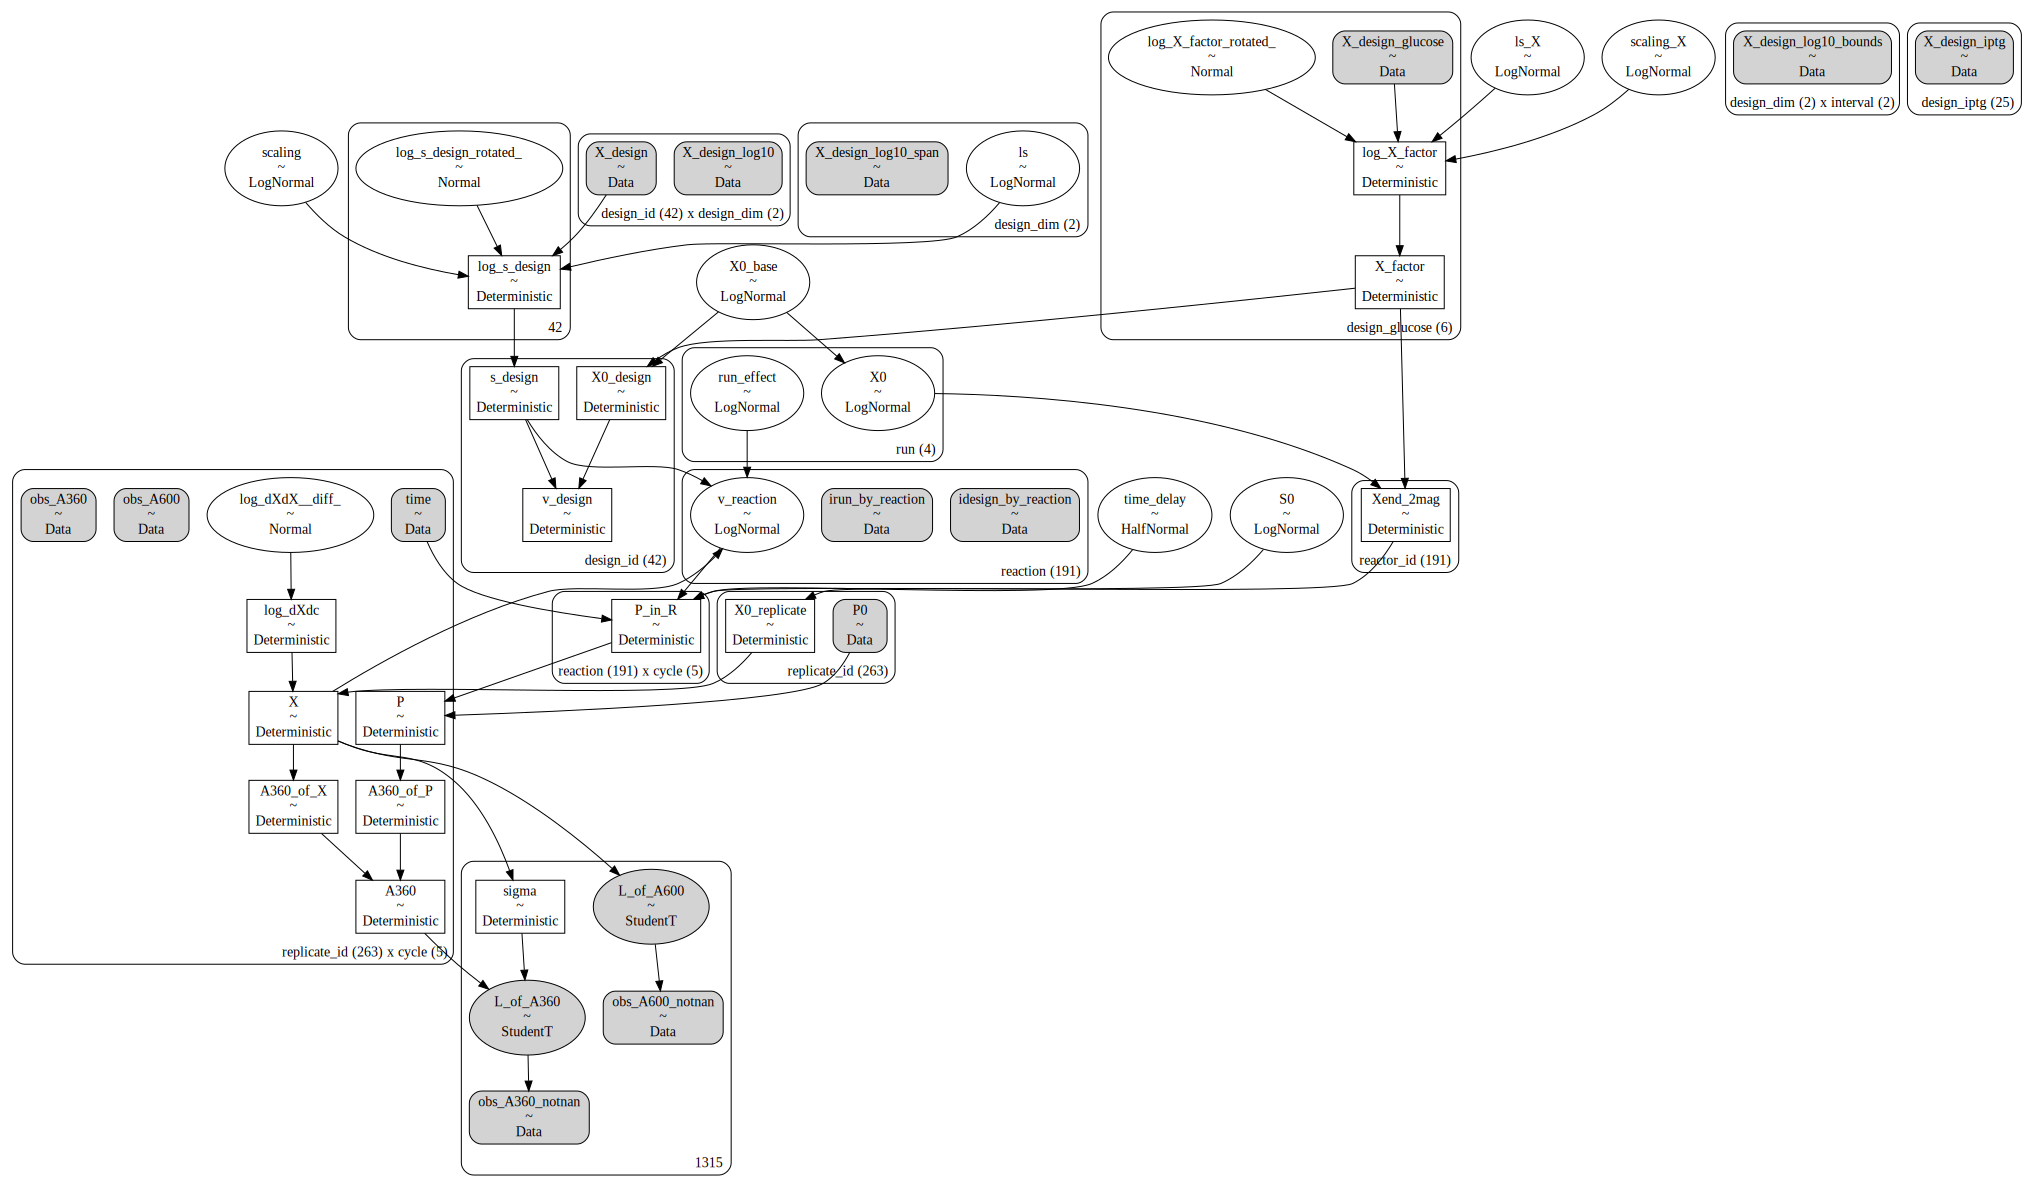

In [6]:
with pm.Model() as pmodel:
    pmodel = models.build_model(
        df_layout,    # for mapping reaction and assay wells
        df_time,
        df_A360,
        df_A600,
        cmX360,       # for learning about X from A360
        cmX600,       # for learning about X from A600
        cmP360,       # for learning about P from A360
        design_cols=design_cols,
    )

# Optional: Plot the model in plate notation
graph = pm.model_to_graphviz(pmodel)
#graph.format = "svg"
#graph.render(filename="03.3_model")
display(graph)

### Hit the inference button!

In [5]:
fp = pathlib.Path("03.3_trace.nc")
with pmodel:
    idata = pm.sample()
idata.to_netcdf(fp)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\users\osthege\repos\pymc-main\pymc\model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ls_X, scaling_X, log_X_factor_rotated_, X0_base, X0, log_dXdX__diff_, S0, time_delay, s_design, run_effect, v_reaction]
c:\users\osthege\repos\pymc-main\pymc\model.py:925: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 1563 seconds.
The number of effective samples is smaller than 10% for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Nov 17 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

matplotlib: 3.4.2
ipywidgets: 7.6.3
arviz     : 0.11.4
numpy     : 1.21.0
aesara    : 2.2.6
pymc      : 4.0.0
pandas    : 1.3.0

Watermark: 2.2.0

